In [2]:
! pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 48.6 MB/s 
     |████████████████████████████████| 895 kB 43.1 MB/s 
     |████████████████████████████████| 636 kB 38.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 241 kB 5.3 MB/s 


In [3]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

100% 4.74M/4.74M [00:00<00:00, 47.1MB/s]

 86% 30.0M/34.8M [00:00<00:00, 24.9MB/s]
100% 34.8M/34.8M [00:00<00:00, 42.1MB/s]
  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 72.7MB/s]
100% 2.51M/2.51M [00:00<00:00, 19.1MB/s]

  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 6.91MB/s]
 92% 25.0M/27.2M [00:00<00:00, 58.7MB/s]
100% 27.2M/27.2M [00:00<00:00, 76.5MB/s]


In [6]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk 
import unidecode
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
!ls

attributes.csv.zip	      relevance_instructions.docx  test.csv.zip
kaggle.json		      sample_data		   train.csv.zip
product_descriptions.csv.zip  sample_submission.csv.zip


In [8]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
train_df= pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [9]:
desc_df = desc_df.fillna(0)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
train_df['product_uid'] = train_df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [10]:
train_df.sample(2)

,id,product_uid,product_title,search_term,relevance
54890,166367,165703,Honeywell 14 in. x 20 in. HW Allergen Plus Ple...,honeywell dehimid filter,2.33
17605,54317,114152,Earthquake 43 cc Earth Auger Powerhead,hole,1.67


In [11]:
np.min(train_df['relevance'].tolist()), np.max(train_df['relevance'].tolist())

(1.0, 3.0)

In [12]:
sorted(pd.unique(train_df['relevance']).tolist())

[1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0]

In [13]:
train_df['my_relevance'] = train_df['relevance'].apply(lambda x: (x - 1.0)/2.0)

In [14]:
np.min(train_df['my_relevance'].tolist()), np.max(train_df['my_relevance'].tolist())

(0.0, 1.0)

In [15]:
train_df['my_relevance2'] = train_df['my_relevance'].apply(lambda x: ((x - 0.0)/1.0) * 2.0 + 1)

In [16]:
train_df[['relevance', 'my_relevance', 'my_relevance2']].sample(4)

,relevance,my_relevance,my_relevance2
68689,2.67,0.835,2.67
12142,2.33,0.665,2.33
74039,2.33,0.665,2.33
71117,2.33,0.665,2.33


In [17]:
train_df.describe()

,id,product_uid,relevance,my_relevance,my_relevance2
count,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634,0.690817,2.381634
std,64016.573650,30770.774864,0.533984,0.266992,0.533984
min,2.000000,100001.000000,1.000000,0.000000,1.000000
25%,57163.500000,115128.500000,2.000000,0.500000,2.000000
50%,113228.000000,137334.000000,2.330000,0.665000,2.330000
75%,168275.500000,166883.500000,3.000000,1.000000,3.000000
max,221473.000000,206650.000000,3.000000,1.000000,3.000000


In [24]:
train_df.drop_duplicates(["product_uid"]).shape[0]/len(train_df)

0.7380749861611784

In [ ]:
# pd.merge(train_df, desc_df, how='left', on='product_uid').shape[0]

74067

In [ ]:
train_df.shape[0]

74067

In [18]:
EMPTY_STRING = ''
SPACE = ' '
def clean_text(string):
  if string is None:
    return None

  string = string.strip().lower()
  string = unidecode.unidecode(string)
  string = string.replace("'", EMPTY_STRING)
  string = re.sub(r"\'n", SPACE, string)
  string = re.sub(r"\'s", " 's", string)
  string = re.sub(r"\'ve", " 've", string)
  string = re.sub(r"n\'t", " n't", string)
  string = re.sub(r"\'re", " 're", string)
  string = re.sub(r"\'d", " 'd", string)
  string = re.sub(r"\'ll", " 'll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " ( ", string)
  string = re.sub(r"\)", " ) ", string)
  string = re.sub(r"\?", r" \? ", string)
  string = re.sub(r"\s{2,}", SPACE, string)
  string = re.sub(r" +", SPACE, string)
  string = re.sub(r"/", " / ", string)
  string = re.sub(r"\|", " | ", string)
  string = re.sub(r"-", " - ", string)
  string = re.sub(r"\+", " + ", string)
  string = re.sub(r"\\\\", SPACE, string)

  return string.strip()


In [19]:
_characters_to_clean = string.punctuation + "''"
EN_STOP_WORDS = set(stopwords.words('english')) - set(['can', 'no', 'up', 'against', 'after', 'before', 'below'])

PUNCTUATIONS = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~'

PUNCTUATIONS_PATTERN = re.compile("[{}]+$".format(re.escape(PUNCTUATIONS)))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def _is_punctuation_only(word: str):
    return PUNCTUATIONS_PATTERN.match(word)

def filter_ale_punctuation(words):
    return [word for word in words if not _is_punctuation_only(word)] if words is not None else None

def tokenize(text):
  
  processed_text = clean_text(text)
  tokens = nltk.word_tokenize(processed_text)

  
  tokens = [stemmer.stem(word) for word in tokens]
  tokens = [word for word in tokens if word not in _characters_to_clean and word not in EN_STOP_WORDS]
  tokens = filter_ale_punctuation(tokens)
  tokens = [re.sub("\d", "#", word) for word in tokens]

  return tokens if len(tokens) > 0 else None


In [ ]:
# tokenize("he went home 123 times, before we --gabi op. -;[]")

['went', 'home', '###', 'time', 'befor', 'gabi', 'op']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0.9997299742125373

In [20]:
train_df['product_title_tokens'] = train_df['product_title'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:40<00:00, 1842.93it/s]


In [21]:
train_df['search_term_tokens'] = train_df['search_term'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:15<00:00, 4690.10it/s]


In [22]:

test_df['product_title_tokens'] = test_df['product_title'].progress_apply(tokenize)


100%|██████████| 166693/166693 [01:29<00:00, 1866.63it/s]


In [23]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(tokenize)

100%|██████████| 166693/166693 [00:34<00:00, 4813.74it/s]


In [24]:
pd.set_option("max_colwidth", -1)

original_train_df_length = len(train_df)
train_df = train_df[train_df['search_term_tokens'].notnull()]
len(train_df)/original_train_df_length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0.9997299742125373

In [52]:
train_df.sample(3)

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens,relevance_class
20655,63776,117392,Milwaukee Electricians Work Belt,MILWAUKEE TOOL BELT,3.00,1.000,3.00,"[milwauke, electrician, work, belt]","[milwauke, tool, belt]",0
40553,123688,142305,Hedrix 11 oz. Match of 314 Red Cedar Low Lustre Custom Spray Paint (2-Pack),cedar spray,2.33,0.665,2.33,"[hedrix, ##, oz, match, ###, red, cedar, low, lustr, custom, spray, paint, #, pack]","[cedar, spray]",2
3887,12078,102115,MOEN Banbury Single-Handle Pull-Out Sprayer Kitchen Faucet in Spot Resist Stainless,moen kitchen faucet brambury,2.33,0.665,2.33,"[moen, banburi, singl, handl, pull, sprayer, kitchen, faucet, spot, resist, stainless]","[moen, kitchen, faucet, bramburi]",2


In [53]:
all_words = [word for words in train_df['search_term_tokens'].tolist() for word in words]
all_words.extend([word for words in train_df['product_title_tokens'].tolist() for word in words])


In [54]:
WORD_REPLACE_MENT = '<word>'
PAD_WORD = "<pad>"

In [80]:
from collections import Counter
# sentenses = train_df['search_term_tokens'].tolist()
# sentenses.extend(train_df['product_title_tokens'].tolist())
counts = Counter(all_words)


In [81]:
MIN_WORD_COUNT = 3

In [82]:
vocab_words = set(all_words)
vocab_size_before_threshold = len(vocab_words)
vocab_words = {word for word in vocab_words if counts[word] >= MIN_WORD_COUNT}
vocab_size_before_threshold, len(vocab_words), len(all_words)

(10328, 10328, 1055648)

In [83]:
train_df['product_title_tokens'] = train_df['product_title_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 252696.30it/s]


In [84]:
train_df['search_term_tokens'] = train_df['search_term_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 134714.66it/s]


In [85]:
test_df['product_title_tokens'] = test_df['product_title_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])
test_df['search_term_tokens'] = test_df['search_term_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words] if words is not None else [])

100%|██████████| 166693/166693 [00:00<00:00, 455384.03it/s]


In [86]:
train_df[train_df['product_title_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens,relevance_class


In [87]:
train_df[train_df['search_term_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens,relevance_class


In [126]:
vocab = {word: index + 2 for (index, word) in enumerate(vocab_words - {PAD_WORD, WORD_REPLACE_MENT})}
vocab[PAD_WORD] = 0 
vocab[WORD_REPLACE_MENT] = 1
PAD_WORD_ID = vocab[PAD_WORD]

In [127]:
# len(vocab), torch.max(search_term), type(vocab)
# token_id_to_word[10329], vocab['martha'], len(vocab), {x for x in range(0, len(vocab)+1) if x not in token_id_to_word}
# {(word, index +2) for (index, word) in enumerate(vocab_words) if index +2 == 7828}


In [128]:
token_id_to_word = {id: word for (word, id) in vocab.items()}
len(token_id_to_word), len(vocab)

(10329, 10329)

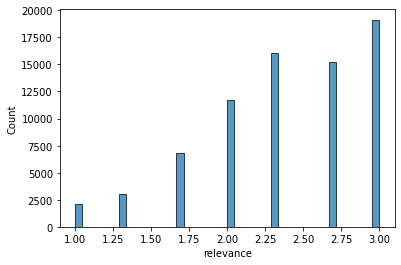

In [38]:
import seaborn as sns
sns.histplot(data=train_df, x="relevance")


In [65]:
relevance_values = pd.unique(train_df['relevance']).tolist()

relevance_map = {relevance: index for (index, relevance) in enumerate(relevance_values)}
num_of_classes = len(relevance_map)
relevance_map, num_of_classes

({1.0: 5,
  1.25: 8,
  1.33: 7,
  1.5: 11,
  1.67: 6,
  1.75: 10,
  2.0: 4,
  2.25: 12,
  2.33: 2,
  2.5: 1,
  2.67: 3,
  2.75: 9,
  3.0: 0},
 13)

In [66]:
train_df['relevance_class'] = train_df['relevance'].apply(lambda relevance: relevance_map[relevance])
pd.unique(train_df['relevance_class'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

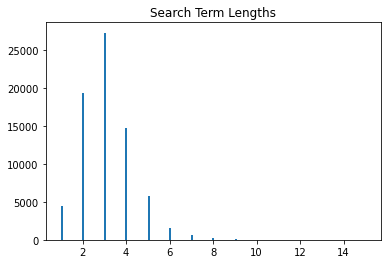

In [67]:
import matplotlib.pyplot as plt

search_term_lengths = train_df['search_term_tokens'].map(len).tolist()
_ = plt.hist(search_term_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Search Term Lengths")
plt.show()

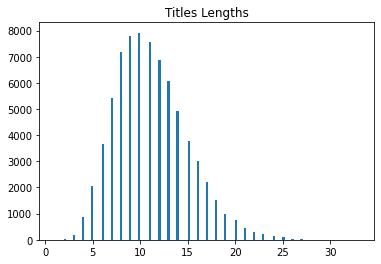

In [68]:
import matplotlib.pyplot as plt

title_lengths = train_df['product_title_tokens'].map(len).tolist()
_ = plt.hist(title_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Titles Lengths")
plt.show()

In [69]:
MAX_SEARCH_TERM_LENGTH = 5
MAX_TITLE_LENGTH = 15

In [129]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df, vocab):
        self._df = df
        self._vocab = vocab

    def __len__(self):
        return len(self._df)

    def _fix_words(self, words_ids, required_size):
        if len(words_ids) > required_size:
            # ids = np.random.choice(len(words_ids), required_size)
            words_ids = words_ids[0: required_size]
        elif len(words_ids) < required_size:
            b = np.zeros(required_size - len(words_ids), dtype=int)
            words_ids = np.concatenate((words_ids, b), axis=None)

        return words_ids

    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array([self._vocab[w] for w in row['search_term_tokens']])
        search_term_length = min(len(search_term), MAX_SEARCH_TERM_LENGTH)
        search_term = self._fix_words(search_term, MAX_SEARCH_TERM_LENGTH)


        product_title = np.array([self._vocab[w] for w in row['product_title_tokens']])
        product_title_length = min(len(product_title), MAX_TITLE_LENGTH)
        product_title = self._fix_words(product_title, MAX_TITLE_LENGTH)

   

        return row['id'], search_term, search_term_length, product_title, product_title_length, row['my_relevance']
    


In [45]:
train_df.sample(1)

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens,relevance_class
6053,19036,103419,Miracle-Gro 0.75 cu. ft. Garden Soil for Flowers and Vegetables,miracle grow spray dispensers,1.67,0.335,1.67,"[miracl, gro, #.##, cu, ft., garden, soil, flower, veget]","[miracl, grow, spray, dispens]",6


In [130]:
BATCH_SIZE = 64
train_data_df = train_df[['id', 'product_title_tokens', 'search_term_tokens', 'my_relevance', 'relevance', 'relevance_class']]
train_data_df['my_relevance'] = train_data_df['relevance_class']
data_loader = DatasetLoader(train_data_df, vocab)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)

test_df['my_relevance'] = -1

test_loader = DatasetLoader(test_df[['id', 'product_title_tokens', 'search_term_tokens', 'my_relevance']], vocab)

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader)

74047

In [131]:
for ids, search_term, search_term_length, product_title, product_title_length, relevance_score in train_data_loader:
  break

In [73]:
relevance_score

tensor([0, 3, 0, 2, 5, 2, 3, 3, 2, 6, 2, 6, 4, 2, 2, 3, 3, 4, 2, 3, 3, 3, 2, 2,
        0, 3, 5, 3, 2, 2, 0, 2, 5, 4, 5, 4, 6, 0, 5, 6, 0, 2, 4, 0, 2, 3, 2, 0,
        4, 0, 2, 2, 2, 7, 2, 0, 3, 2, 3, 3, 4, 6, 2, 3])

In [61]:
[token_id_to_word[x] for x in product_title[4].numpy().tolist()]


['ge',
 'profil',
 'advantium',
 '##',
 'electr',
 'wall',
 'oven',
 'speed',
 'cook',
 'convect',
 'stainless',
 'steel',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
product_title_length[1]

tensor(11)

In [62]:
train_df[train_df['id'] == ids[4].numpy().item()]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens
41975,127829,144360,GE Profile Advantium 30 in. Electric Wall Oven with Speed Cook and Convection in Stainless Steel,built in oven microwave 30 in,2.33,0.665,2.33,"[ge, profil, advantium, ##, electr, wall, oven, speed, cook, convect, stainless, steel]","[built, oven, microwav, ##]"


In [63]:
search_term.shape, search_term_length.shape , product_title.shape , product_title_length.shape  

(torch.Size([5, 5]), torch.Size([5]), torch.Size([5, 15]), torch.Size([5]))

In [132]:
class EncoderModel(nn.Module):

    def __init__(self, n_vocab):
        super(EncoderModel, self).__init__()
        self.lstm_size = 100
        self.embedding_dim = 300
        

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )

        self.rnn = nn.LSTM(self.embedding_dim, 300, 1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(600, 300)
        self.fc2 = nn.Linear(300, 100)

    def forward(self, x, lengths):

        embed = self.embedding(x)
            
        packed_input = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        
        packed_output, hn = self.rnn(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        
        out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]
        out_reverse = output[:, 0, self.embedding_dim :]
        out = torch.cat((out_forward, out_reverse), 1)
        
        #out = torch.tanh(out_reduced)
        out = self.fc1(out)
        out = torch.tanh(out)
        out = self.fc2(out)

        return out
    
    def reset_parameters(self):
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)

        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        

class RelevanceModel(nn.Module):

  def __init__(self, n_vocab, num_of_classes):
    super(RelevanceModel, self).__init__()
    self.query_encoder = EncoderModel(n_vocab)#.to(device)
    self.title_encoder = EncoderModel(n_vocab)#.to(device)
    self.fc = nn.Linear(200, num_of_classes)
    

  def  forward(self, queries, titles, queries_lengths, titles_lengths):
    encoded_queries = self.query_encoder(queries, queries_lengths)
    title_encoded = self.title_encoder(titles, titles_lengths)

    out = torch.cat((encoded_queries, title_encoded), 1)
    #out = torch.tanh(out)

  
    out = self.fc(out)
    
    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc.weight)
    self.query_encoder.reset_parameters()
    self.title_encoder.reset_parameters()
    

# class RelevanceModel(nn.Module):

#   def __init__(self, n_vocab):
#     super(RelevanceModel, self).__init__()
#     self.encoder = EncoderModel(n_vocab)#.to(device)
#     #self.title_encoder = EncoderModel(n_vocab)#.to(device)
#     self.fc = nn.Linear(200, 1)

#   def  forward(self, queries, titles, queries_lengths, titles_lengths):
#     encoded_queries = self.encoder(queries, queries_lengths)
#     encoded_queries = self.encoder(titles, titles_lengths)

#     out = torch.cat((query_encoded, title_encoded), 1).to(device)
#     out = torch.tanh(out)

  
#     out = self.fc(out)

#     return torch.sigmoid(out)

#   def reset_parameters(self):
#     nn.init.uniform_(self.fc.weight)
#     self.encoder.reset_parameters()
    


In [110]:

# # for x in model.parameters():
# #   if not x.is_cuda:
# #     print(x) 

# # e1 = EncoderModel(len(vocab)).to(device)
# # r = e1(product_title.to(device), product_title_length)
# output.shape, product_title_length
# #output = r 

# #8
# #out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]

# # output[range(len(output)), product_title_length - 1, :300][0]
# product_title_length
#output[0][14], product_title_length

tensor([14, 12, 10, 15,  8])

In [118]:
# output[0][13][300:]
# output[:, 0, 300 :].shape, output[:, 0,]


(torch.Size([5, 300]), torch.Size([5, 15, 600]))

In [133]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# query_encoder = EncoderModel(len(vocab))
# title_encoder = EncoderModel(len(vocab))

# query_encoder.reset_parameters()
# title_encoder.reset_parameters()

# #search_term, search_term_length, product_title, product_title_length
# query_encoded = query_encoder(search_term, search_term_length)
# title_encoded = query_encoder(product_title, product_title_length)
# torch.cat((query_encoded, title_encoded), 1)

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [115]:
len(vocab), vocab[]

KeyError: ignored

In [91]:
model = RelevanceModel(len(vocab), num_of_classes)
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(
        model.parameters(), lr=0.0005)

# criterion  = nn.MSELoss(reduction='sum').to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)

# model(search_term, product_title, search_term_length,  product_title_length)

In [100]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device
# for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
#   break

# search_term = Variable(search_term).to(device)
# product_title = Variable(product_title).to(device)
# model(search_term, product_title, search_term_length,  product_title_length)


(10329, tensor(10329), dict)

In [92]:

model.train()

for epoc in range(1000):

  running_loss = 0.0
  counter = 0.0

  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).float().to(device)

    optimizer.zero_grad()

    scores = model(search_term, product_title, search_term_length,  product_title_length)
    loss = criterion(scores, target_relevance_score.long())

    

    loss.backward()
    optimizer.step()

    #nn.utils.clip_grad_norm(model.parameters(), 0.5)
    
    running_loss += loss.item()
    counter = search_term.shape[0]
  #   break
  
  # break
  
  print('epoc {} loss {} counter {}'.format(epoc, running_loss/counter, counter))




IndexError: ignored

In [70]:
# mse_loss(scores.view(1, -1), target_relevance_score.view(1, -1))
# counter
F.softmax(scores, dim=0)[0:2], scores[0:2], target_relevance_score[0:2]

(tensor([[0.0156],
         [0.0156]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[0.7205],
         [0.7205]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([0.8350, 0.5000], dtype=torch.float64))

In [94]:


model.eval()
test_scores = []
test_ids =[]
tt = []
for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
  search_term = Variable(search_term).to(device)
  product_title = Variable(product_title).to(device)
  

  scores = model(search_term, product_title, search_term_length,  product_title_length)

  test_scores.extend(scores.detach().cpu().numpy().flatten().tolist())
  test_ids.extend(ids.numpy().tolist())
  tt.extend(target_relevance_score.numpy().tolist())

  break
  



In [95]:
list(zip(test_scores, tt))

[(2.1742067337036133, 2.67),
 (2.1742067337036133, 3.0),
 (2.633699417114258, 2.0),
 (2.1742067337036133, 2.33),
 (2.1742067337036133, 3.0),
 (2.1742067337036133, 2.33),
 (2.633699417114258, 3.0),
 (2.1742067337036133, 2.33),
 (2.6340579986572266, 1.0),
 (2.633699417114258, 2.33),
 (2.1742067337036133, 1.67),
 (2.633699417114258, 3.0),
 (2.1742067337036133, 3.0),
 (2.633699417114258, 3.0),
 (2.1742067337036133, 2.67),
 (2.1742067337036133, 1.67),
 (2.1742067337036133, 2.33),
 (2.1742067337036133, 2.33),
 (2.1742067337036133, 3.0),
 (2.1742067337036133, 2.33),
 (2.1742067337036133, 1.33),
 (2.633699417114258, 2.67),
 (2.633699417114258, 1.33),
 (2.1742067337036133, 2.0),
 (2.633699417114258, 2.67),
 (2.633699417114258, 2.0),
 (2.1742067337036133, 1.33),
 (2.633707046508789, 2.67),
 (2.1741838455200195, 3.0),
 (2.6325931549072266, 3.0),
 (2.633699417114258, 2.67),
 (2.1742067337036133, 2.67),
 (2.633699417114258, 1.67),
 (2.1742067337036133, 1.67),
 (2.633699417114258, 2.67),
 (2.1742067

In [59]:
scores.detach().cpu().flatten().numpy().tolist()[17]

0.40383392572402954